# Color Segmentation with K-means Clustering

In [4]:
from matplotlib import pyplot as plt
import cv2
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
%matplotlib inline


Input image

(-0.5, 865.5, 1299.5, -0.5)

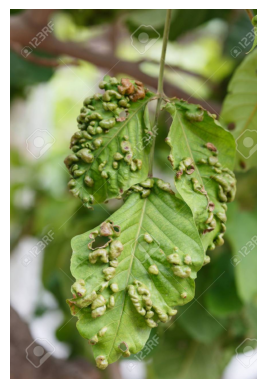

In [15]:
image = cv2.imread(r"./LeafDisease5.jpg", cv2.IMREAD_UNCHANGED)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis('off')

## Extract objects

Convert image to gray:

(-0.5, 865.5, 1299.5, -0.5)

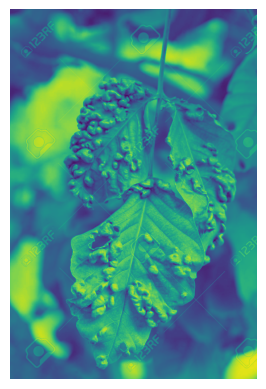

In [16]:
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
plt.imshow(gray)
plt.axis('off')

Apply binary threshold and erode:

True

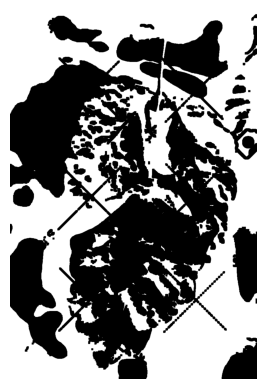

In [17]:
_ , mask = cv2.threshold(gray, 140, 255, cv2.THRESH_BINARY_INV)
mask = cv2.equalizeHist(mask)
mask = cv2.erode(mask, np.ones((7, 7), np.uint8))
#mask = cv2.erode(mask, np.ones((2, 2), np.uint8))
plt.imshow(mask, cmap = "gray")
plt.axis('off')
cv2.imwrite('thresholding.png', cv2.hconcat([image, np.stack((mask, mask, mask), axis=2)]))

Find contours and display all contours:

(-0.5, 865.5, 1299.5, -0.5)

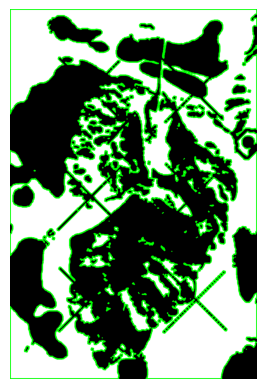

In [18]:
contours, _ = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_TC89_L1)

contours_img_before_filtering = mask.copy()
contours_img_before_filtering = cv2.cvtColor(contours_img_before_filtering, cv2.COLOR_GRAY2BGR)
cv2.drawContours(contours_img_before_filtering, contours, -1, (0, 255, 0), 3)
plt.imshow(contours_img_before_filtering)
plt.axis('off')

Filter Contours and extract Mean Colors

In [19]:
filtered_contours = []
df_mean_color = pd.DataFrame()
for idx, contour in enumerate(contours):
    area = int(cv2.contourArea(contour))

    # if area is higher than 3000:
    if area > 100:
        filtered_contours.append(contour)
        # get mean color of contour:
        masked = np.zeros_like(image[:, :, 0])  # This mask is used to get the mean color of the specific bead (contour), for kmeans
        cv2.drawContours(masked, [contour], 0, 255, -1)

        B_mean, G_mean, R_mean, _ = cv2.mean(image, mask=masked)
        df = pd.DataFrame({'B_mean': B_mean, 'G_mean': G_mean, 'R_mean': R_mean}, index=[idx])
        df_mean_color = pd.concat([df_mean_color, df])

df_mean_color.head()

,B_mean,G_mean,R_mean
3,59.453744,125.757709,102.215859
10,17.013942,106.614702,80.185467
13,15.051522,98.833724,84.498829
17,18.386905,103.470238,92.988095
22,18.895450,107.298793,81.144847


Display filtered contours

True

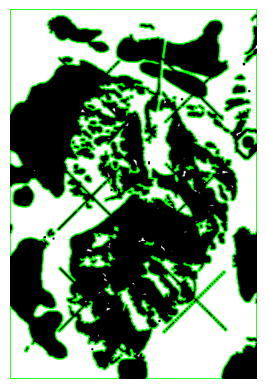

In [20]:
contours_img_after_filtering = mask.copy()
contours_img_after_filtering = cv2.cvtColor(contours_img_after_filtering, cv2.COLOR_GRAY2BGR)
cv2.drawContours(contours_img_after_filtering, tuple(filtered_contours), -1, (0, 255, 0), 3)

plt.imshow(contours_img_after_filtering)
plt.axis('off')

cv2.imwrite('contours.png', cv2.hconcat([contours_img_before_filtering, contours_img_after_filtering]))

## K-means clustering

In [21]:
km = KMeans( n_clusters=2)
df_mean_color['label'] = km.fit_predict(df_mean_color)

df_mean_color

/Users/ketansharma14/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


,B_mean,G_mean,R_mean,label
3,59.453744,125.757709,102.215859,0
10,17.013942,106.614702,80.185467,1
13,15.051522,98.833724,84.498829,1
17,18.386905,103.470238,92.988095,1
22,18.895450,107.298793,81.144847,1
...,...,...,...,...
147,75.555556,156.775354,134.980606,0
149,79.848024,156.212006,134.250760,0
150,76.284436,154.677996,132.601073,0
152,89.164835,134.464286,123.928571,0


(-0.5, 865.5, 1299.5, -0.5)

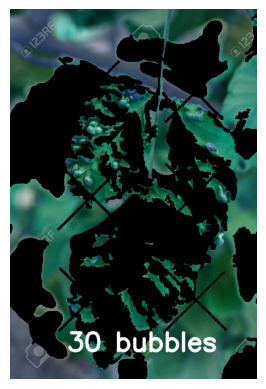

In [23]:
img = image.copy()
for label, df_grouped in df_mean_color.groupby('label'):
    bubbles_amount = len(df_grouped)
    masked_image = draw_segmented_objects(image, contours, df_grouped.index, bubbles_amount)
    img = cv2.hconcat([masked_image])

cv2.imwrite('color_segmentation.png', img)
plt.imshow(img)
plt.axis('off')

# Functions Steps

In [32]:
def input_image(path):
    image = cv2.imread(path, cv2.IMREAD_UNCHANGED)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    
    return image

In [33]:
def pre_processing_image(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    plt.imshow(gray)
    plt.axis('off')
    
    _ , mask = cv2.threshold(gray, 140, 255, cv2.THRESH_BINARY_INV)
    mask = cv2.equalizeHist(mask)
    mask = cv2.erode(mask, np.ones((7, 7), np.uint8))
    #mask = cv2.erode(mask, np.ones((2, 2), np.uint8))
    plt.imshow(mask, cmap = "gray")
    plt.axis('off')
    #cv2.imwrite('thresholding.png', cv2.hconcat([image, np.stack((mask, mask, mask), axis=2)]))
    
    return mask

In [34]:
def get_mean_color_df(mask):
    contours, _ = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_TC89_L1)

    contours_img_before_filtering = mask.copy()
    contours_img_before_filtering = cv2.cvtColor(contours_img_before_filtering, cv2.COLOR_GRAY2BGR)
    cv2.drawContours(contours_img_before_filtering, contours, -1, (0, 255, 0), 3)
    plt.imshow(contours_img_before_filtering)
    plt.axis('off')
    
    filtered_contours = []
    df_mean_color = pd.DataFrame()
    for idx, contour in enumerate(contours):
        area = int(cv2.contourArea(contour))

        # if area is higher than 3000:
        if area > 100:
            filtered_contours.append(contour)
            # get mean color of contour:
            masked = np.zeros_like(image[:, :, 0])  # This mask is used to get the mean color of the specific bead (contour), for kmeans
            cv2.drawContours(masked, [contour], 0, 255, -1)

            B_mean, G_mean, R_mean, _ = cv2.mean(image, mask=masked)
            df = pd.DataFrame({'B_mean': B_mean, 'G_mean': G_mean, 'R_mean': R_mean}, index=[idx])
            df_mean_color = pd.concat([df_mean_color, df])

    df_mean_color.head()
    return df_mean_color

In [40]:
def k_means_clustering(df_mean_color):
    km = KMeans( n_clusters=2, n_init=2)
    df_mean_color['label'] = km.fit_predict(df_mean_color)

    return df_mean_color

In [36]:
def draw_segmented_objects(image, contours, label_cnt_idx, bubbles_count):
    mask = np.zeros_like(image[:, :, 0])
    cv2.drawContours(mask, [contours[i] for i in label_cnt_idx], -1, (255), -1)
    masked_image = cv2.bitwise_and(image, image, mask=mask)
    masked_image = cv2.putText(masked_image, f'{bubbles_count} bubbles', (200, 1200), cv2.FONT_HERSHEY_SIMPLEX,
                        fontScale = 3, color = (255, 255, 255), thickness = 10, lineType = cv2.LINE_AA)
    return masked_image

In [37]:
def get_segmented_image(df_mean_color, image):
    img = image.copy()
    for label, df_grouped in df_mean_color.groupby('label'):
        bubbles_amount = len(df_grouped)
        masked_image = draw_segmented_objects(image, contours, df_grouped.index, bubbles_amount)
        img = cv2.hconcat([masked_image])
    return img

(-0.5, 865.5, 1299.5, -0.5)

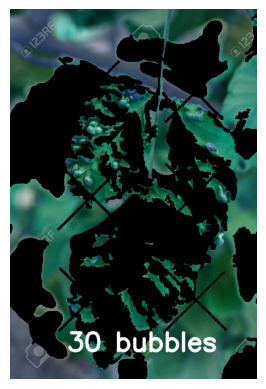

In [41]:
path = "./LeafDisease5.jpg"

image = input_image(path)
mask = pre_processing_image(image)
df = get_mean_color_df(mask)
df = k_means_clustering(df)
img = get_segmented_image(df, image)

cv2.imwrite('color_segmentation.png', img)
plt.imshow(img)
plt.axis('off')